### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error    


import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv('train.csv', index_col='id')
test_df = pd.read_csv('test.csv', index_col='id')


In [4]:
train_df

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...
90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6


In [5]:
# Make different lists for numeric, categorical, and target variables
numeric = list(train_df._get_numeric_data())
categ = list(train_df.drop(numeric, axis = 1))
target='Rings'
numeric.remove(target)

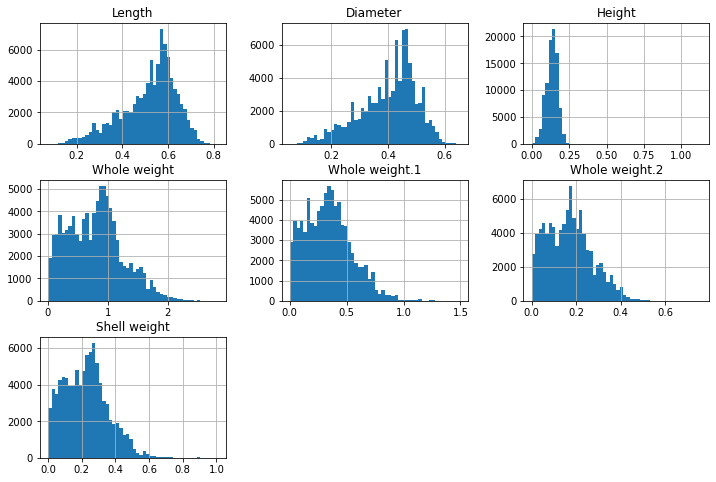

In [6]:
# Check the distribution for each column
train_df[numeric].hist(bins=50, figsize=(12,8))
plt.show()

In [7]:
#no null columns
train_df.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [8]:
#only one object column which is sex can be converted to numerical
train_df.dtypes 

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Whole weight.1    float64
Whole weight.2    float64
Shell weight      float64
Rings               int64
dtype: object

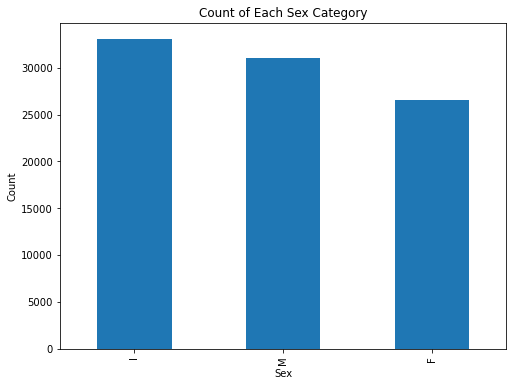

In [9]:
# three categories
sex_counts = train_df['Sex'].value_counts() 

plt.figure(figsize=(8, 6))
sex_counts.plot(kind='bar')
plt.title('Count of Each Sex Category')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

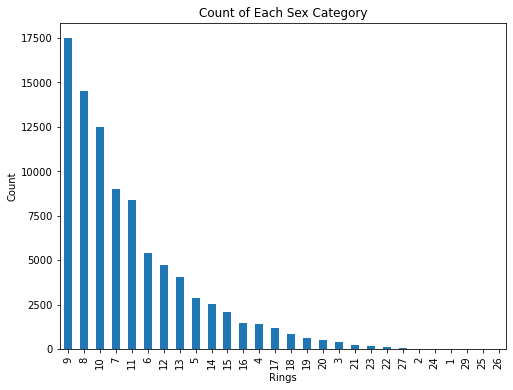

In [10]:
#Distribution of the target variable
ring_counts = train_df['Rings'].value_counts(ascending=False) 

plt.figure(figsize=(8, 6))
ring_counts.plot(kind='bar')
plt.title('Count of Each Sex Category')
plt.xlabel('Rings')
plt.ylabel('Count')
plt.show()

In [11]:
#Convert the categorical variables into numerical
le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])

train_df_numeric = train_df

In [12]:
train_df_numeric

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,0,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,1,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,2,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,1,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...
90610,2,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,2,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,1,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6


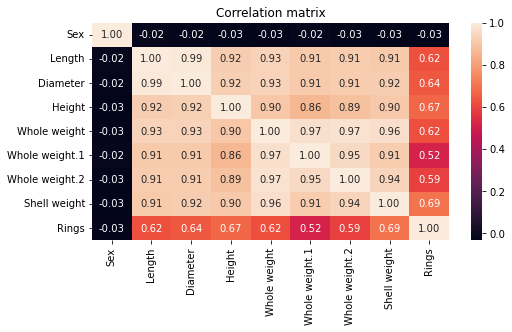

In [13]:
corr = train_df_numeric.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(corr, annot=True, fmt="0.2f")
plt.title("Correlation matrix")
plt.show()

In [14]:
#CHecking if the sex column is important, and its distribution
grouped_means = train_df_numeric.groupby('Sex')['Rings'].mean()

print(grouped_means)

Sex
0    11.161389
1     7.533557
2    10.753408
Name: Rings, dtype: float64


In [15]:
train_df_numeric.describe()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,1.050014,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,0.795174,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,1.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,2.000000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,2.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


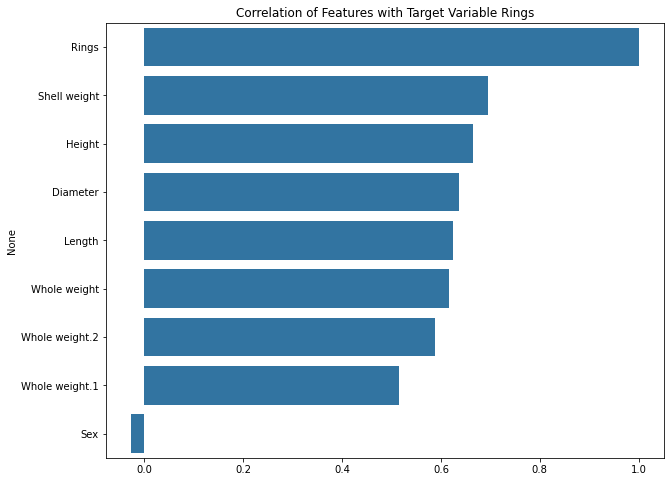

In [16]:
#how correlated every numeric feature is with the target variable(sex has the least relation with the target variable)
correlation = train_df_numeric.corrwith(train_df_numeric['Rings']).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation.values, y=correlation.index)
plt.title('Correlation of Features with Target Variable Rings')
plt.show()

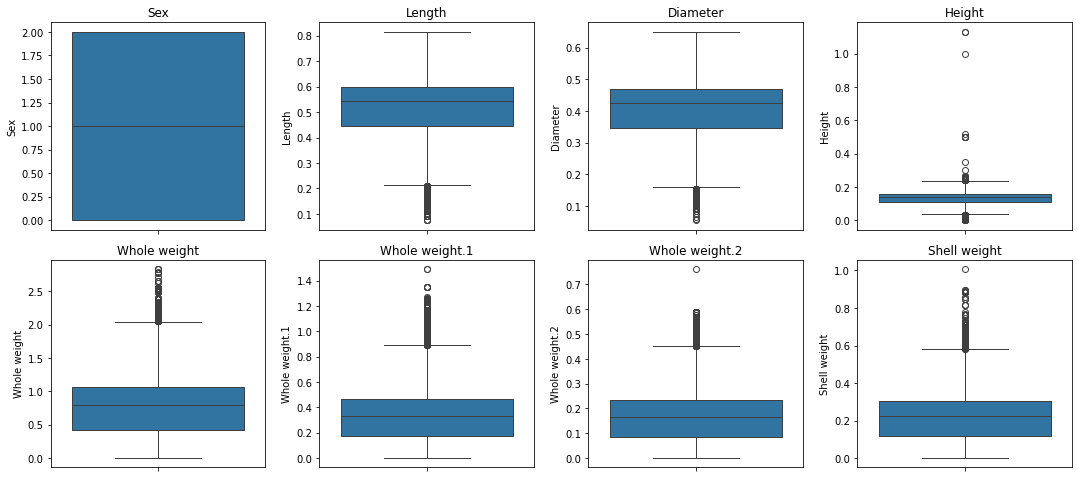

In [17]:
y = train_df_numeric['Rings']
X = train_df_numeric.drop('Rings', axis=1)

plt.figure(figsize=(15, 10))

for i, column in enumerate(X):
    plt.subplot(3, 4, i+1)
    sns.boxplot(y=X[column])
    plt.title(column)

plt.tight_layout()
plt.show()

In [18]:
def remove_outliers_iqr(df, columns):
    for column in columns:
        percentile25 = df[column].quantile(0.25)
        percentile75 = df[column].quantile(0.75)
        iqr = percentile75 - percentile25
        upper_limit = percentile75 + 1.5 * iqr
        lower_limit = percentile25 - 1.5 * iqr
        
        df = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
    
    return df

columns_to_check = ['Length','Diameter','Height','Whole weight','Whole weight.1','Whole weight.2', 'Shell weight']  # Specify your columns here
new_df = remove_outliers_iqr(train_df_numeric, columns_to_check)

print(f"Original size: {train_df_numeric.shape}, After outlier removal: {new_df.shape}")

Original size: (90615, 9), After outlier removal: (86766, 9)


In [19]:
new_df

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,0,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
3,2,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,1,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
5,0,0.610,0.480,0.170,1.2010,0.5335,0.3135,0.3085,10
...,...,...,...,...,...,...,...,...,...
90610,2,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,2,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,1,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6


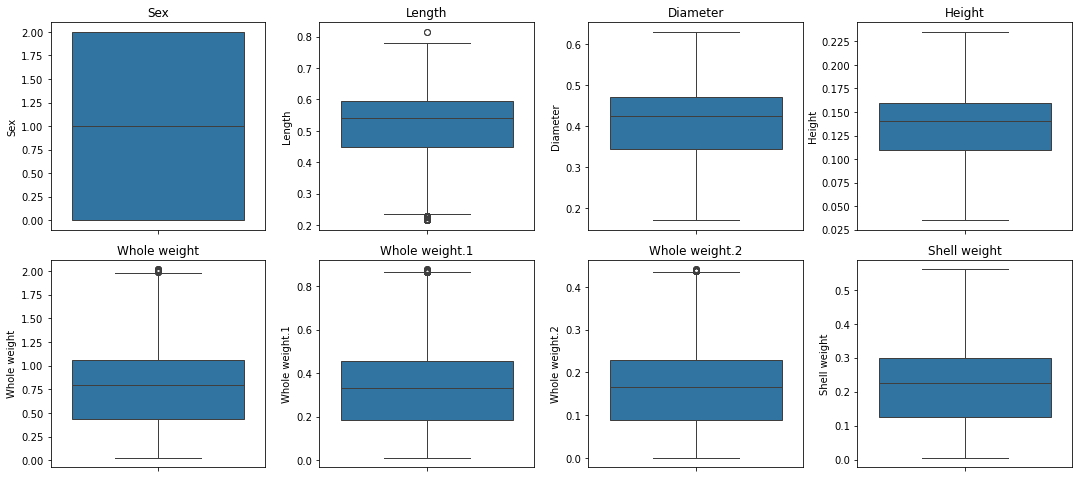

In [20]:
y = new_df['Rings']
X = new_df.drop('Rings', axis=1)

plt.figure(figsize=(15, 10))

for i, column in enumerate(X):
    plt.subplot(3, 4, i+1)
    sns.boxplot(y=X[column])
    plt.title(column)

plt.tight_layout()
plt.show()

### Also tried log transformation on original train_df_numeric

In [21]:
# # List of columns to transform
# #columns_to_check = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Sex_F', 'Sex_I', 'Sex_M']
# columns_to_check = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']

# # Additional columns to include without transformation
# additional_columns = ['Sex','Rings']

# # Apply log transformation for specified columns
# log_transformed_df = pd.DataFrame()
# for column in columns_to_check:
#     log_transformed_df[column + '_log'] = np.log1p(train_df_numeric[column])

# # Include additional columns from the original DataFrame
# log_transformed_df[additional_columns] = train_df_numeric[additional_columns]

# # Verify the resulting DataFrame
# log_transformed_df.head()


### Also after removing outliers data

In [22]:
# List of columns to transform
#columns_to_check = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Sex_F', 'Sex_I', 'Sex_M']
columns_to_check = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']

# Additional columns to include without transformation
additional_columns = ['Sex','Rings']

# Apply log transformation for specified columns
log_transformed_df = pd.DataFrame()
for column in columns_to_check:
    log_transformed_df[column + '_log'] = np.log1p(new_df[column])

# Include additional columns from the original DataFrame
log_transformed_df[additional_columns] = new_df[additional_columns]

# Verify the resulting DataFrame
log_transformed_df.head()

,Length_log,Diameter_log,Height_log,Whole weight_log,Whole weight.1_log,Whole weight.2_log,Shell weight_log,Sex,Rings
id,,,,,,,,,
0,0.438255,0.357674,0.139762,0.571827,0.284050,0.136714,0.215111,0,11
1,0.488580,0.398776,0.135405,0.756122,0.377066,0.244122,0.277632,0,11
3,0.466874,0.388658,0.139762,0.649456,0.318817,0.186894,0.223144,2,10
4,0.441476,0.354172,0.122218,0.577736,0.314446,0.148420,0.180236,1,9
5,0.476234,0.392042,0.157004,0.788912,0.427553,0.272695,0.268881,0,10


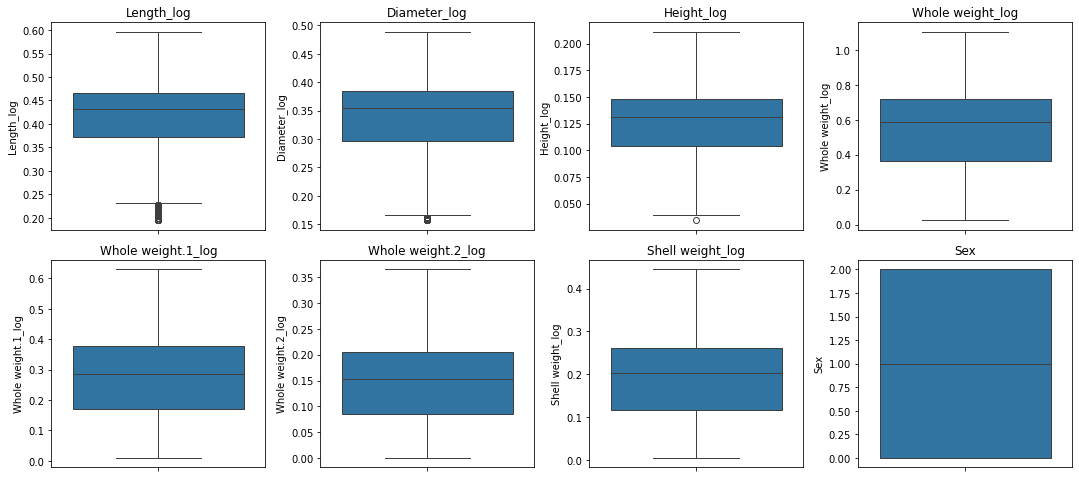

In [25]:
y = log_transformed_df['Rings']
X = log_transformed_df.drop('Rings', axis=1)

plt.figure(figsize=(15, 10))

for i, column in enumerate(X):
    plt.subplot(3, 4, i+1)
    sns.boxplot(y=X[column])
    plt.title(column)

plt.tight_layout()
plt.show()

In [85]:
# # # List of columns to transform
# # #columns_to_check = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Sex_F', 'Sex_I', 'Sex_M']
# # olumns_to_check = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
# 
# # # Additional columns to include without transformation
# # additional_columns = ['Rings']
# 
# # # Apply log transformation for specified columns
# # log_transformed_df = pd.DataFrame()
# # for column in columns_to_check:
# #     log_transformed_df[column + '_log'] = np.log1p(train_df_numeric[column])
# 
# # # Include additional columns from the original DataFrame
# # log_transformed_df[additional_columns] = train_df_numeric[additional_columns]
# 
# # # Verify the resulting DataFrame
# # log_transformed_df.head()
# 


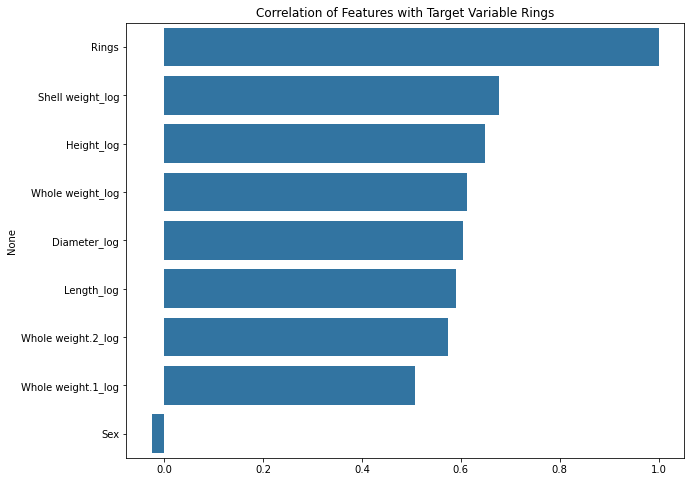

In [26]:
correlation = log_transformed_df.corrwith(log_transformed_df['Rings']).sort_values(ascending=False)
#correlation = new_df.corrwith(new_df['Rings']).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation.values, y=correlation.index)
plt.title('Correlation of Features with Target Variable Rings')
plt.show()

### Linear Regression

In [27]:
X = log_transformed_df.drop('Rings', axis=1)
y = log_transformed_df['Rings']


# X = new_df.drop('Rings', axis=1)
# y = new_df['Rings']

#scaler = MinMaxScaler(feature_range=(-1,1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred_lin = model_lin.predict(X_val)

In [30]:
def rmsle(y_true, y_pred):
    log_pred = np.log1p(y_pred)
    log_true = np.log1p(y_true)
    
    # Calculate the squared difference
    squared_error = np.square(log_pred - log_true)
    
    # Calculate the mean of squared differences and take the square root
    rmsle = np.sqrt(np.mean(squared_error))
    
    return rmsle

In [31]:
rmsle_score_lin = rmsle(y_val, y_pred_lin)
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle_score_lin}")

Root Mean Squared Logarithmic Error (RMSLE): 0.16212608426717615


### Desicion tree regression

In [32]:
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [33]:
y_pred_dt = model_dt.predict(X_val)

In [34]:
rmsle_score_dt = rmsle(y_val, y_pred_dt)
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle_score_dt}")

Root Mean Squared Logarithmic Error (RMSLE): 0.2143008752606274


### XGBoost

In [35]:
xgboost_params = {
    'max_depth': 10, 
    'verbosity': 0,
    'random_state':42,
    'booster': 'gbtree',
    'n_estimators': 1137, 
    'tree_method': 'hist',
    'min_child_weight': 7, 
    'grow_policy': 'lossguide', 
    'gamma': 0.03816426816838989, 
    'subsample': 0.486382907668344, 
    'objective': 'reg:squarederror',
    'reg_lambda': 1.7487237399420372, 
    'reg_alpha': 0.013043045359306716,
    'learning_rate': 0.011733966748427322, 
    'colsample_bytree': 0.5748511749872887, 
}
model_xgb = xgb.XGBRegressor(**xgboost_params)

scores = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

In [36]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.5748511749872887, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.03816426816838989, gpu_id=-1, grow_policy='lossguide',
             importance_type=None, interaction_constraints='',
             learning_rate=0.011733966748427322, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=1137, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [37]:
# Making predictions
y_pred_xgb = model_xgb.predict(X_val)

rmsle_score_xgb = rmsle(y_val, y_pred_xgb)
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle_score_xgb}")

Root Mean Squared Logarithmic Error (RMSLE): 0.1497329767075609


In [38]:
feature_importances_xgb = model_xgb.feature_importances_

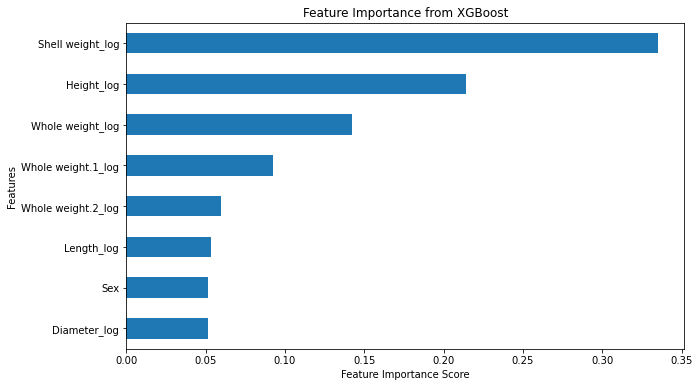

In [39]:
plt.figure(figsize=(10, 6))
feature_importance_series = pd.Series(feature_importances_xgb, index=X.columns)
feature_importance_series.sort_values().plot(kind='barh')
plt.title('Feature Importance from XGBoost')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

### RandomForestRegressor

In [40]:
model = SVR(kernel='rbf')
model.fit(X_train, y_train)

y_pred = model.predict(X_val)


rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))

print("Root Mean Squared Logarithmic Error (RMSLE):", rmsle)

Root Mean Squared Logarithmic Error (RMSLE): 0.15887247676502222


### Working with the test data(need to transform, so can be predicted)

In [41]:
# Perform label encoding on the test data
le = LabelEncoder()
test_df['Sex'] = le.fit_transform(test_df['Sex'])

In [44]:
test_df

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
90615,2,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
90616,2,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
90617,2,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
90618,2,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
90619,1,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050
...,...,...,...,...,...,...,...,...
151021,1,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500
151022,0,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050
151023,1,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650


In [46]:
columns_to_check = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']

# Additional columns to include without transformation
additional_columns = ['Sex']

# Apply log transformation for specified columns
log_test_df = pd.DataFrame()
for column in columns_to_check:
    log_test_df[column + '_log'] = np.log1p(test_df[column])

# Include additional columns from the original DataFrame
log_test_df[additional_columns] = test_df[additional_columns]

# Verify the resulting DataFrame
log_test_df.head()

,Length_log,Diameter_log,Height_log,Whole weight_log,Whole weight.1_log,Whole weight.2_log,Shell weight_log,Sex
id,,,,,,,,
90615,0.497740,0.388658,0.144100,0.805583,0.481500,0.271934,0.262749,2
90616,0.457425,0.378436,0.148420,0.684611,0.391028,0.198441,0.242946,2
90617,0.444686,0.350657,0.131028,0.609494,0.301955,0.169321,0.215515,2
90618,0.451076,0.398776,0.135405,0.628075,0.301955,0.171008,0.211071,2
90619,0.347130,0.281412,0.104360,0.306013,0.146263,0.064851,0.099845,1


In [47]:
y_pred_test = model_xgb.predict(log_test_df)
y_pred_test_rounded = np.round(y_pred_test).astype(int)

In [48]:
y_pred_test

array([ 9.747211,  9.637994,  9.832306, ..., 12.712111, 13.386197,
        8.519464], dtype=float32)

In [49]:
predictions_df = pd.DataFrame({
    'id': test_df.index,
    'Rings': y_pred_test
})

In [50]:
predictions_df.to_csv('submission_final.csv', index=False)